# 1. Setup

## 1.1 Install Dependencies

In [8]:
%pip install tensorflow opencv-python matplotlib keras

Note: you may need to restart the kernel to use updated packages.


## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [10]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [11]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_s('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

AttributeError: module 'tensorflow._api.v2.config.experimental' has no attribute 'list_physical_s'

In [ ]:

gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

## 1.4 Create Folder Structures

In [ ]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
# Make the directories
if (not os.path.exists('data')):
    os.makedirs('data')

    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [11]:
if (not os.path.isfile('lfw.tgz')):
    subprocess.run(['curl', 'http://vis-www.cs.umass.edu/lfw/lfw.tgz', '-o', 'lfw.tgz'])

In [12]:
if (not os.path.exists('lfw') and os.path.isfile('lfw.tgz')):
    os.makedirs('lfw')
    !tar -xf lfw.tgz

In [13]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [4]:
# Import uuid library to generate unique image names
import uuid

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

NameError: name 'ANC_PATH' is not defined

In [6]:
#Now access webcam here...
cap = cv2.VideoCapture(0)

while cap.isOpened():

    # Read a camera point in time
    ret, frame = cap.read()

    frame = frame[0:0+250, 50:50+250, :]


    # Collect anchor    
    key = cv2.waitKey(1)
    if key == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Collect positive
    key = cv2.waitKey(1)
    if key == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    cv2.imshow('Imamge Collection', frame)

    key = cv2.waitKey(1)
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

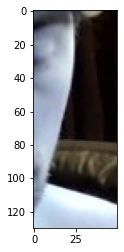

In [14]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 2.x NEW - Data Augmentation

In [15]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [16]:
import os
import uuid

In [12]:
img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [21]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

KeyboardInterrupt: 

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [18]:
dir_test = anchor.as_numpy_iterator()

In [19]:
print(dir_test.next())

b'data\\anchor\\7fcf87e8-b6a7-11ed-bbb9-08d23e23cf16.jpg'


## 3.2 Preprocessing - Scale and Resize

In [20]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

## 3.3 Create Labelled Dataset

In [21]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
exampple = samples.next()

In [25]:
exampple

(b'data\\anchor\\76f73a3c-b6a7-11ed-afe7-08d23e23cf16.jpg',
 b'data\\positive\\5fd4562b-b6a7-11ed-ba26-08d23e23cf16.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*exampple)

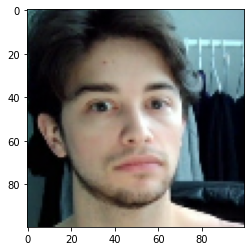

In [28]:
plt.imshow(res[1])

In [29]:
res[2]

1.0

In [30]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [31]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [33]:
inp = Input(shape=(100,100,3), name='input_image')

In [34]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [35]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [36]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [37]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [38]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [39]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [41]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
embedding = make_embedding()

In [43]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [44]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [45]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [46]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [47]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [48]:
siamese_layer = L1Dist()

In [49]:
distances = siamese_layer(inp_embedding, val_embedding)

In [50]:
classifier = Dense(1, activation='sigmoid')(distances)

In [51]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [52]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [54]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_model = make_siamese_model()

In [56]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [57]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [58]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [59]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [60]:
test_batch = train_data.as_numpy_iterator()

In [61]:
batch_1 = test_batch.next()

In [62]:
X = batch_1[:2]

In [63]:
y = batch_1[2]

In [64]:
y

array([1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [65]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [66]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [67]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [68]:
EPOCHS = 25

In [ ]:
#   try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#   except RuntimeError as e:
#     print(e)

In [78]:
# with tf.device('/GPU:0'):
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
30/30 [==============================] - 591s 20s/step
0.11023581 0.9756098 0.9160305

 Epoch 2/50
30/30 [==============================] - 574s 19s/step
0.008254395 1.0 0.99570817

 Epoch 3/50
30/30 [==============================] - 563s 19s/step
0.00416788 1.0 0.9957983

 Epoch 4/50
30/30 [==============================] - 559s 19s/step
0.0017417847 1.0 1.0

 Epoch 5/50
30/30 [==============================] - 559s 19s/step
6.311993e-05 1.0 1.0

 Epoch 6/50
30/30 [==============================] - 581s 19s/step
0.0003440187 1.0 1.0

 Epoch 7/50
30/30 [==============================] - 578s 19s/step
0.000744196 1.0 1.0

 Epoch 8/50
30/30 [==============================] - 558s 19s/step
1.3823178e-05 1.0 1.0

 Epoch 9/50
30/30 [==============================] - 559s 19s/step
2.330007e-06 1.0 1.0

 Epoch 10/50
30/30 [====

# 6. Evaluate Model

## 6.1 Import Metrics

In [69]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [70]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [71]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


In [91]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

In [92]:
y_true

array([0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [93]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.875

In [94]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.53846157

In [95]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 276ms/step
0.8313253 0.36125654


## 6.4 Viz Results

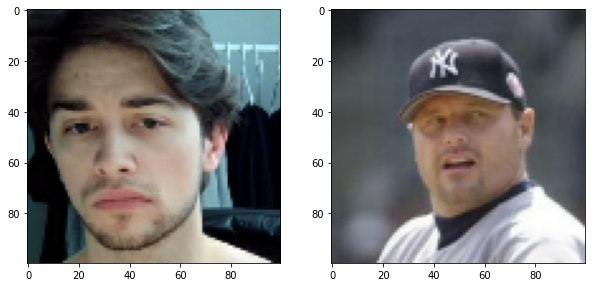

In [96]:
# Set plot size 
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

# 7. Save Model

In [94]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [97]:
L1Dist


__main__.L1Dist

In [98]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [100]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 290ms/step


array([[0.95125693],
       [0.97735643]], dtype=float32)

In [101]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [97]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [98]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\71a08ad2-b62c-11ed-a9c8-08d23e23cf16.jpg
application_data\verification_images\71aeb1ec-b62c-11ed-803e-08d23e23cf16.jpg
application_data\verification_images\71c3b22e-b62c-11ed-860a-08d23e23cf16.jpg
application_data\verification_images\71d22739-b62c-11ed-8e97-08d23e23cf16.jpg
application_data\verification_images\71e74e70-b62c-11ed-8408-08d23e23cf16.jpg
application_data\verification_images\71f57594-b62c-11ed-9904-08d23e23cf16.jpg
application_data\verification_images\72060c09-b62c-11ed-9a48-08d23e23cf16.jpg
application_data\verification_images\72145a1e-b62c-11ed-9808-08d23e23cf16.jpg
application_data\verification_images\72225a4a-b62c-11ed-999b-08d23e23cf16.jpg
application_data\verification_images\7237f661-b62c-11ed-92d0-08d23e23cf16.jpg
application_data\verification_images\7246926a-b62c-11ed-a041-08d23e23cf16.jpg
application_data\verification_images\72546ba1-b62c-11ed-a20b-08d23e23cf16.jpg
application_data\verification_images\7265020f-b62c-11ed-b790-08d

In [102]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [131]:
#Now access webcam here...
cap = cv2.VideoCapture(0)

while cap.isOpened():

    # Read a camera point in time
    ret, frame = cap.read()

    frame = frame[0:0+250, 50:50+250, :]

    # Collect positive
    key = cv2.waitKey(1)
    if key == ord('v'):        
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.6, 0.7)
        print(verified)

    cv2.imshow('Imamge Collection', frame)

    key = cv2.waitKey(1)
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 221ms/step
True
1/1 [==============================] - 0s 196ms/step
True
1/1 [==============================] - 0s 192ms/step
False
1/1 [==============================] - 0s 189ms/step
True
1/1 [==============================] - 0s 195ms/step
False
1/1 [==============================] - 0s 196ms/step
True
1/1 [==============================] - 0s 232ms/step
True


In [132]:
results, verified = verify(siamese_model, 0.65, 0.65)
print(verified)

1/1 [==============================] - 0s 207ms/step
True


In [129]:
np.sum(np.squeeze(results) > 0.7)

25

In [104]:
results

[array([[4.09523e-06]], dtype=float32),
 array([[3.4364505e-06]], dtype=float32),
 array([[7.054389e-06]], dtype=float32),
 array([[4.5957418e-06]], dtype=float32),
 array([[3.423435e-06]], dtype=float32),
 array([[5.322448e-06]], dtype=float32),
 array([[2.3260684e-06]], dtype=float32),
 array([[2.7273024e-06]], dtype=float32),
 array([[6.438501e-07]], dtype=float32),
 array([[7.415066e-07]], dtype=float32),
 array([[9.897653e-07]], dtype=float32),
 array([[1.0905551e-06]], dtype=float32),
 array([[1.4050768e-06]], dtype=float32),
 array([[1.0152428e-06]], dtype=float32),
 array([[1.4552722e-06]], dtype=float32),
 array([[5.825995e-06]], dtype=float32),
 array([[5.168159e-06]], dtype=float32),
 array([[8.459524e-06]], dtype=float32),
 array([[9.379928e-06]], dtype=float32),
 array([[4.685956e-06]], dtype=float32),
 array([[6.886179e-06]], dtype=float32),
 array([[5.4755856e-05]], dtype=float32),
 array([[0.00018818]], dtype=float32),
 array([[4.316037e-05]], dtype=float32),
 array([[2